In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.vgg19 import VGG19
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Obtener la data 

In [2]:
fpath = 'C:/Users/JOSE/Documents/Septimo/Mineria/Image_processing/Dataset_bg_normales'
random_seed = 9

categories = os.listdir(fpath)
print("Categorias Encontradas = ",categories)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))


Categorias Encontradas =  ['Blackrot', 'Esca', 'Healthy', 'Leaf_blight']
List of categories =  ['Blackrot', 'Esca', 'Healthy', 'Leaf_blight'] 

No. of categories =  4


In [3]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels
images, labels = load_images_and_labels(categories)


In [4]:
images = np.array(images)
labels = np.array(labels)
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (400, 256, 256, 3) 
Labels shape =  (400,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


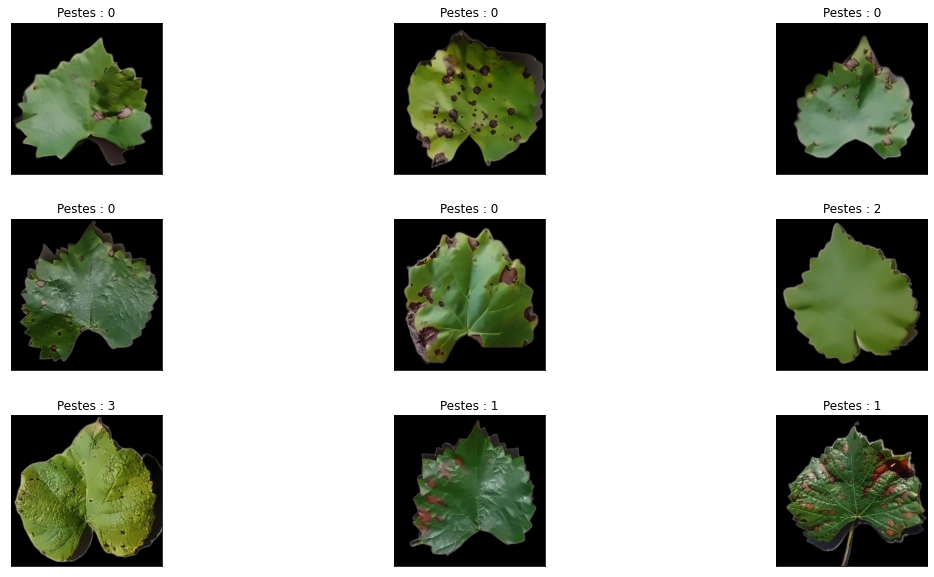

In [5]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Pestes : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)


# Preparar los datos para el entrenamiento

In [6]:
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [7]:
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)


Images shape after shuffling =  (400, 256, 256, 3) 
Labels shape after shuffling =  (400,)


In [8]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (400, 256, 256, 3)


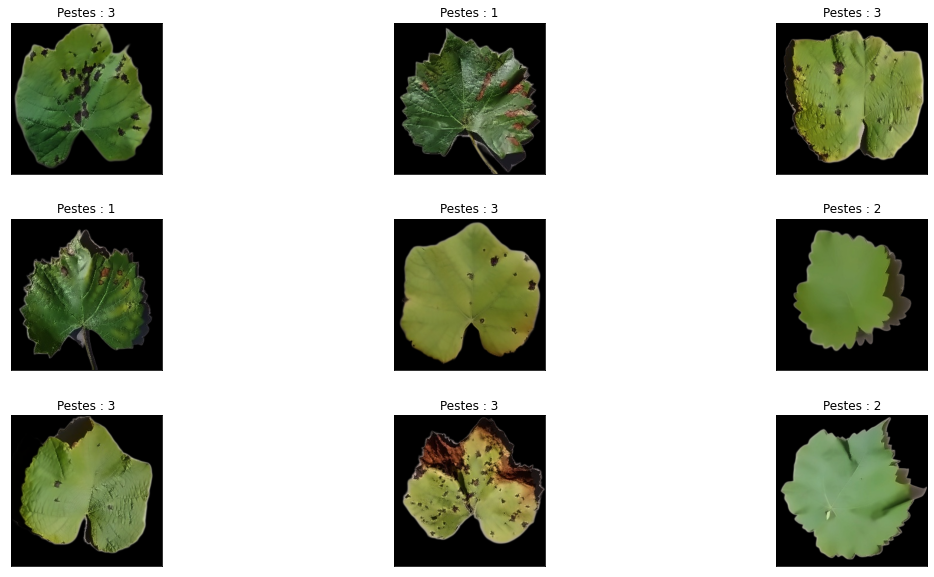

In [9]:
display_rand_images(images, labels)

In [10]:
train_ds, test_ds, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)
print("Tamaño de Caracteristicas Entrenamiento:", train_ds.shape) 
print("Tamaño de Caracteristicas Test:", test_ds.shape)
print("Tamaño de Etiquetas Entrenamiento:", train_labels.shape)
print("Tamaño de Etiquetas Test:", test_labels.shape)

Tamaño de Caracteristicas Entrenamiento: (320, 256, 256, 3)
Tamaño de Caracteristicas Test: (80, 256, 256, 3)
Tamaño de Etiquetas Entrenamiento: (320,)
Tamaño de Etiquetas Test: (80,)


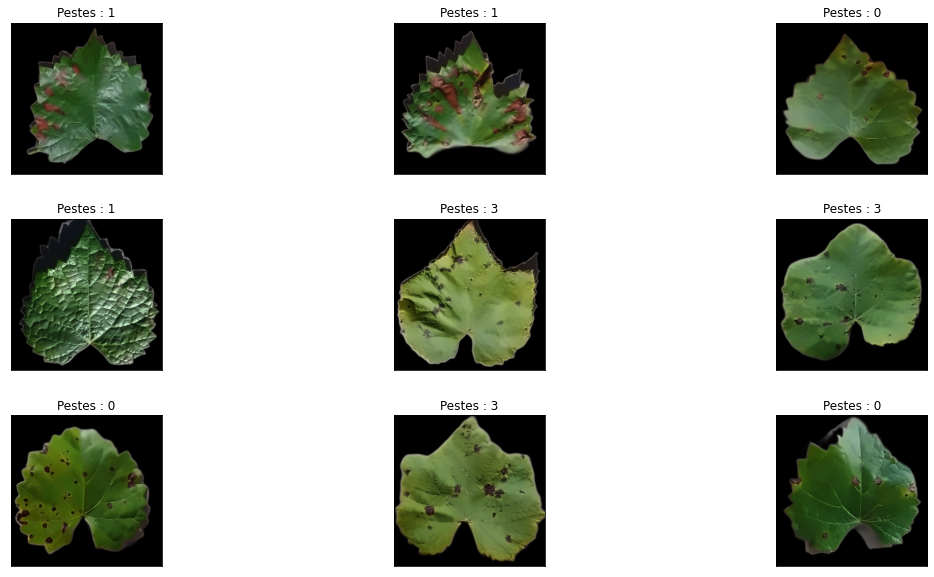

In [11]:
#Ejemplo de variables de entrenamiento
display_rand_images(train_ds, train_labels)

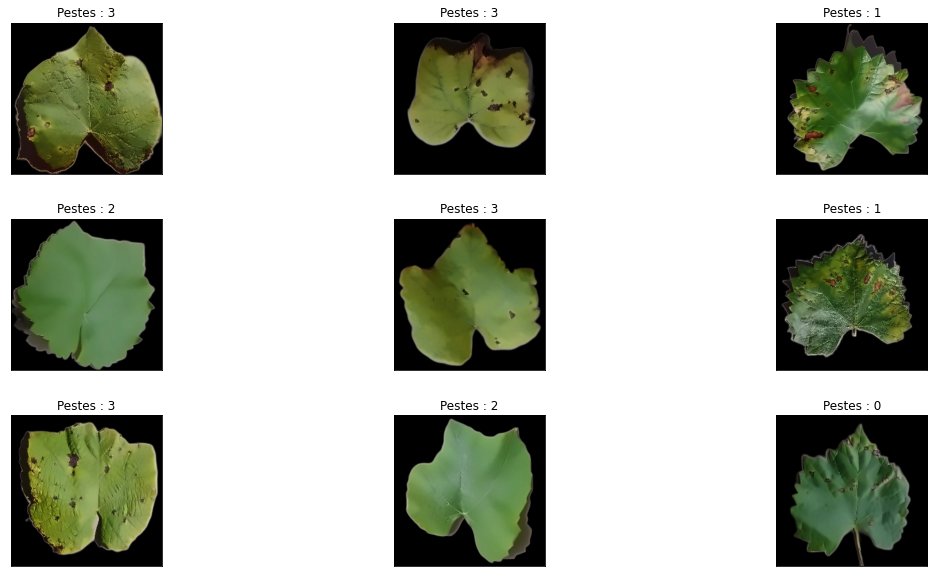

In [12]:
#Ejemplo de variables de test
display_rand_images(test_ds, test_labels)

In [13]:
#Asignar el nuevo valor de tamaño a las imagenes
X_train = tf.image.resize(train_ds, (150, 150))
X_test = tf.image.resize(test_ds, (150, 150))
print("Okey..")

Okey..


# Modelo cnn

In [14]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [24]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

# Entrenamiento del Modelo Convusional

In [26]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
history = model.fit(train_ds, train_labels, epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
8/8 [==============================] - 48s 6s/step - loss: 1.8054 - accuracy: 0.2266 - val_loss: 1.6421 - val_accuracy: 0.2812
Epoch 2/5
8/8 [==============================] - 49s 6s/step - loss: 1.6188 - accuracy: 0.2656 - val_loss: 1.5554 - val_accuracy: 0.2500
Epoch 3/5
8/8 [==============================] - 51s 7s/step - loss: 1.5598 - accuracy: 0.2500 - val_loss: 1.4710 - val_accuracy: 0.2500
Epoch 4/5
8/8 [==============================] - 61s 8s/step - loss: 1.5036 - accuracy: 0.2344 - val_loss: 1.4423 - val_accuracy: 0.2500
Epoch 5/5
8/8 [==============================] - 65s 9s/step - loss: 1.4374 - accuracy: 0.2852 - val_loss: 1.4026 - val_accuracy: 0.3281


In [19]:
_, acc = model.evaluate(test_ds, test_labels, verbose=0)

print('> %.2f' % (acc * 100.0))

> 21.25


In [20]:
model_probs = model.predict(test_ds, verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(test_labels, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(test_labels, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 21.25
F1 score: 7.45
Precision: 4.52
Recall: 21.25


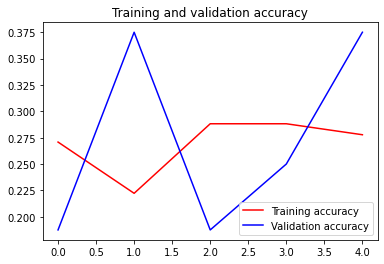

<Figure size 432x288 with 0 Axes>

In [21]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

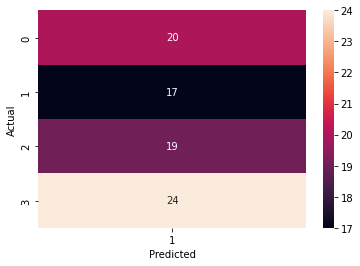

In [23]:
confusion_matrix = pd.crosstab(test_labels, model_classes, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()